In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import các mô hình
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # Cần cài đặt: pip install xgboost
from sklearn.metrics import ConfusionMatrixDisplay


# Import các công cụ đánh giá
from sklearn.metrics import classification_report, accuracy_score

# Tải bộ dữ liệu đã có đầy đủ đặc trưng
FINAL_FEATURES_PATH = '../data/processed/dataset_final_features.csv'
df = pd.read_csv(FINAL_FEATURES_PATH)

# Chuẩn bị X và y
X = df.drop(columns=['url', 'label'])
y = df['label']

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dữ liệu đã sẵn sàng!")
print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

Dữ liệu đã sẵn sàng!
Kích thước tập huấn luyện: (405756, 19)
Kích thước tập kiểm tra: (101439, 19)


In [2]:
# Tạo một từ điển chứa các mô hình bạn muốn so sánh
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

# Tạo một DataFrame để lưu kết quả
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Phishing Precision', 'Phishing Recall', 'Phishing F1-Score', 'Training Time (s)'])

for name, model in models.items():
    print(f"--- Bắt đầu huấn luyện: {name} ---")
    
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    training_time = end_time - start_time
    
    print(f"--- Bắt đầu đánh giá: {name} ---")
    y_pred = model.predict(X_test)
    
    # Lấy các chỉ số từ classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    
    # Thêm kết quả vào DataFrame
    results.loc[len(results)] = [name, accuracy, precision, recall, f1_score, training_time]
    
    print(f"Hoàn thành {name} trong {training_time:.2f} giây.\n")

--- Bắt đầu huấn luyện: Logistic Regression ---
--- Bắt đầu đánh giá: Logistic Regression ---
Hoàn thành Logistic Regression trong 22.54 giây.

--- Bắt đầu huấn luyện: Random Forest ---
--- Bắt đầu đánh giá: Random Forest ---
Hoàn thành Random Forest trong 53.65 giây.

--- Bắt đầu huấn luyện: XGBoost ---


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Bắt đầu đánh giá: XGBoost ---
Hoàn thành XGBoost trong 3.65 giây.



Bảng so sánh hiệu suất các mô hình:


,Model,Accuracy,Phishing Precision,Phishing Recall,Phishing F1-Score,Training Time (s)
1,Random Forest,0.890890,0.821203,0.659405,0.731464,53.651248
2,XGBoost,0.886267,0.847225,0.604287,0.705426,3.646652
0,Logistic Regression,0.829710,0.820887,0.312555,0.452731,22.542303


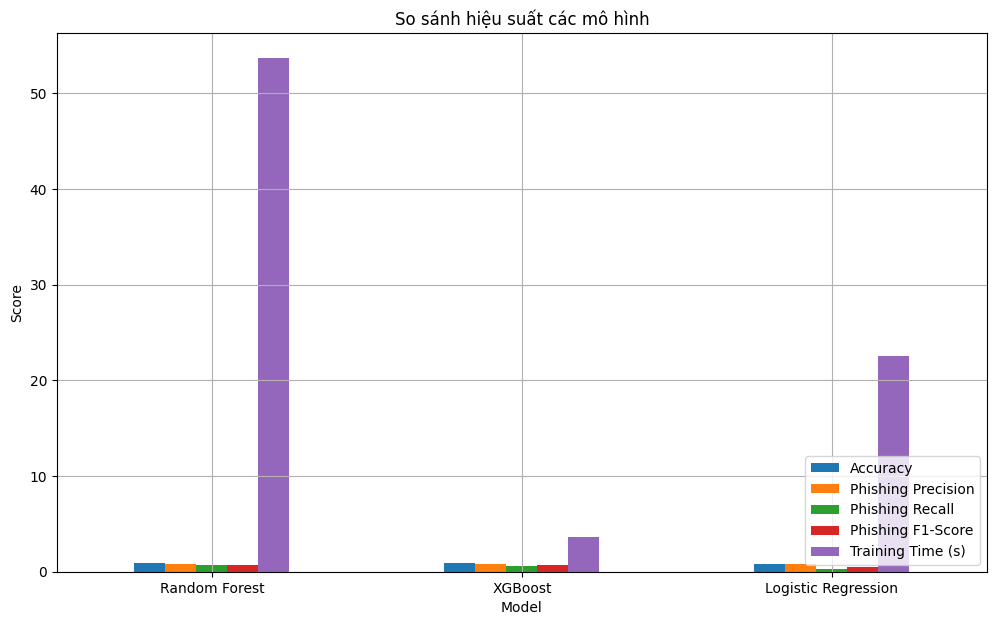

In [3]:
# Sắp xếp kết quả theo F1-score
results.sort_values(by='Phishing F1-Score', ascending=False, inplace=True)

print("Bảng so sánh hiệu suất các mô hình:")
display(results)

# Trực quan hóa
results.set_index('Model').plot(kind='bar', figsize=(12, 7), grid=True)
plt.title("So sánh hiệu suất các mô hình")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [4]:
from sklearn.model_selection import RandomizedSearchCV

print("--- Bắt đầu tinh chỉnh tham số cho XGBoost ---")

# Định nghĩa không gian tham số để tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Khởi tạo RandomizedSearchCV
# n_iter: số lượng kết hợp tham số sẽ thử
# cv: số fold của cross-validation
xgb_tuned = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    param_distributions=param_grid,
    n_iter=15, # Thử 15 kết hợp ngẫu nhiên
    cv=3,
    verbose=2, # Hiển thị tiến trình
    random_state=42,
    scoring='f1' # Tối ưu theo F1-score của lớp dương
)

# Bắt đầu quá trình tìm kiếm
start_time = time.time()
xgb_tuned.fit(X_train, y_train)
end_time = time.time()

print(f"\nHoàn thành tinh chỉnh trong {(end_time - start_time)/60:.2f} phút.")
print(f"Các tham số tốt nhất tìm được: {xgb_tuned.best_params_}")

--- Bắt đầu tinh chỉnh tham số cho XGBoost ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=   9.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=   9.3s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=   9.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.4s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.3s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.1s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   4.7s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   4.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   4.6s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   2.6s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   3.2s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   3.9s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.7s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.9s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.3s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   4.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   4.4s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   4.4s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:21:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   8.4s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.9s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.8s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.9; total time=   6.2s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.9; total time=   6.8s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.9; total time=   6.4s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.8s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.3s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.2s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:22:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=300, subsample=0.9; total time=  16.1s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=300, subsample=0.9; total time=  14.6s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=300, subsample=0.9; total time=  17.0s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   3.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   3.6s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   3.8s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.7s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.9s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.7s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:23:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.5s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:24:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.3s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:24:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   8.0s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:24:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.7s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:24:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.9s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:24:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   6.1s


c:\Users\ASUS\Documents\Projects\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:24:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hoàn thành tinh chỉnh trong 4.59 phút.
Các tham số tốt nhất tìm được: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [5]:
# Lấy ra mô hình tốt nhất
best_xgb = xgb_tuned.best_estimator_

# Đánh giá trên tập test
y_pred_best = best_xgb.predict(X_test)

print("\n--- Báo cáo Phân loại cho Mô hình XGBoost Tốt nhất ---")
print(classification_report(y_test, y_pred_best, target_names=['Legitimate', 'Phishing']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=['Legitimate', 'Phishing'])
plt.title("Confusion Matrix for Tuned XGBoost Model")
plt.show()


--- Báo cáo Phân loại cho Mô hình XGBoost Tốt nhất ---
              precision    recall  f1-score   support

  Legitimate       0.90      0.97      0.93     78579
    Phishing       0.85      0.63      0.72     22860

    accuracy                           0.89    101439
   macro avg       0.88      0.80      0.83    101439
weighted avg       0.89      0.89      0.89    101439



NameError: name 'ConfusionMatrixDisplay' is not defined